Load libraries

In [11]:
import numpy as np
import pandas as pd
import pickle as pkl
import warnings
from tqdm import tqdm

PATH =  "/home/jmurga/mkt/201902"
import sys
sys.path.insert(0, PATH + '/scripts/src/')
from mktAnalysis import *

Load main data

In [2]:
dmelDataset  = pd.read_csv(PATH + "/results/dsimDmelSitesBinned.tsv",sep='\t')
humanDataset = pd.read_csv(PATH + "/results/afrEur.tsv",sep='\t')

In [3]:
%load_ext rpy2.ipython

# Resampling analysis

## Zi

In [ ]:
alphasZi = []
binnedZi = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(np.array([1,2,5,10,25,50,75,100,250,500,750,1000])):
        a, b = sampleAnalysis(df = dmelDataset,population="ZI",sample=i,replicas=1000,dofe=PATH + "/rawData/dofe/pooled",nthreads=20)
        a['bins'] = i; b['bins'] = i
        alphasZi.append(a)
        binnedZi.append(b)
alphasZi = pd.concat(alphasZi)
binnedZi = pd.concat(binnedZi)

In [ ]:
pkl.dump([alphasZi,binnedZi],open(PATH + "/results/pooled/ziPooled.pkl", "wb" ))

Creating bootstrap analysis to test Grapes uncertainity

In [ ]:
grapesBootstrap(bins = np.array([1,2,5,10,25,50,75,100,250,500,750,1000]), replicas = 100, path = PATH + "/rawData/dofe/pooled/zi/")

**Execute grapes before continue**

In [ ]:
df = list()
for i in np.array([1,2,5,10,25,50,75,100,250,500,750,1000]):
    tmp = grapesOutput(PATH + "/rawData/dofe/pooled/zi/"+str(i)+"/bootstrap/","GammaZero",7)
    tmp['bins'] = i
    tmp['pop']  = 'ZI'
    df.append(tmp)
grapesZi = pd.concat(df)
grapesZi.to_csv(PATH + "/results/pooled/bootstrap/grapesBootstrapZi.tsv",sep='\t',index=False)

## Afr

In [ ]:
alphasAfr = []
binnedAfr = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(np.array([1,2,5,10,25,50,75,100,250,500,750,1000,2500,5000])):
        a, b = sampleAnalysis(df = humanDataset,population="AFR",sample=i,replicas=1000,dofe=PATH + "/rawData/dofe/pooled",nthreads=20)
        alphasAfr.append(a)
        binnedAfr.append(b)
alphasAfr = pd.concat(alphasAfr)
binnedAfr = pd.concat(binnedAfr)

In [ ]:
pkl.dump([alphasAfr,binnedAfr],open(PATH + "/results/pooled/afrPooled.pkl", "wb" ))

Creating bootstrap analysis to test Grapes uncertainity

In [ ]:
grapesBootstrap(bins = np.array([1,2,5,10,25,50,75,100,250,500,750,1000,2500,5000]), replicas = 100, path = PATH + "/rawData/dofe/pooled/afr/")

**Execute grapes before continue**

In [ ]:
df = list()
for i in np.array([1,2,5,10,25,50,75,100,250,500,750,1000]):
    tmp = grapesOutput(PATH + "/rawData/dofe/pooled/afr/"+str(i)+"/bootstrap/","GammaZero",7)
    tmp['bins'] = i
    tmp['pop']  = 'AFR'
    df.append(tmp)
grapesAfr = pd.concat(df)
grapesAfr.to_csv(PATH + "/results/pooled/bootstrap/grapesBootstrapAfr.tsv",sep='\t',index=False)

## Eur

In [ ]:
alphasEur = []
binnedEur = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(np.array([1,2,5,10,25,50,75,100,250,500,750,1000])):
        a, b = sampleAnalysis(df = humanDataset,population="EUR",sample=i,replicas=1000,dofe=PATH + "/rawData/dofe/pooled",nthreads=20)
        alphasEur.append(a)
        binnedEur.append(b)
alphasEur = pd.concat(alphasEur)
binnedEur = pd.concat(binnedEur)

In [ ]:
pkl.dump([alphasEur,binnedEur],open(PATH + "/results/pooled/eurPooled.pkl", "wb" ))

## Plot

Loading data from pickle and formating to plot in R

In [4]:
alphas, binned = loadPickleAlphas(PATH + "/results/pooled/*.pkl")

### ZI

In [22]:
alphasZi = alphas['zi']; binnedZi = binned['zi']

In [23]:
grapesPooledZi = []
for i in tqdm(np.array(glob.glob(PATH + "/rawData/dofe/pooled/zi/*"))):
    tmp,tmp2,tmp3 = grapesOutput(i,"GammaZero","ZI",5)
    tmp['bins'] = int(i.split('/')[-1])
    tmp['pop'] = 'ZI'
    grapesPooledZi.append(tmp)
grapesPooledZi = pd.concat(grapesPooledZi)
grapesPooledZi.sort_values('bins',inplace=True)

100%|██████████| 12/12 [00:58<00:00,  4.85s/it]


In [44]:
dfZi = pd.concat([pd.melt(grapesPooledZi,id_vars=['test','bins','pop'],value_vars='alpha'),alphasZi])
dfZi.bins = dfZi.bins.astype(str)
dfZi.bins = pd.Categorical(dfZi.bins,categories=dfZi.bins.unique())

R[write to console]: Saving 14 x 6.67 in image

R[write to console]: Saving 14 x 6.67 in image



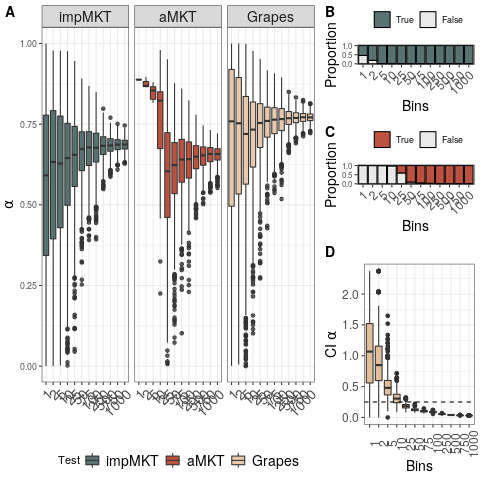

In [45]:
%%R -i binnedZi -i dfZi -i grapesPooledZi -i PATH

library(cowplot)

binnedZi = as.data.table(binnedZi)
grapesPooledZi = as.data.table(grapesPooledZi)
grapesPooledZi[['bins']] = as.factor(grapesPooledZi[['bins']])
dfZi = as.data.table(dfZi)

ci = ggplot(grapesPooledZi,aes(x = bins, y = alpha_range, fill=bins)) + geom_boxplot(show.legend=F) + labs(x = "Bins", y=expression(paste('CI ',alpha))) + theme_bw() + scale_fill_manual(values=c(rep("#e2bd9a",length(grapesPooledZi[['bins']])))) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=90),axis.text.y = element_text(size=12),axis.title=element_text(size=14)) + ggtitle("") + geom_hline(yintercept=0.25,linetype='dashed')

d = dfZi[test == 'imp2' | test == 'asymp1' | test == 'grapes']
d$test = factor(d$test,levels=c('imp2','asymp1','grapes'))
levels(d$test) = c('impMKT','aMKT','Grapes')

p = ggplot(d) + geom_boxplot(aes(x = bins, y = value, fill=test),alpha=0.8,show.legend=T) + labs(x='',y=expression(alpha)) + theme_bw() + ylim(c(0,1)) + scale_fill_manual(values=c("#30504f","#ab2710","#e2bd9a"),name = "Test", labels = c("impMKT", "aMKT","Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=14,angle=45,hjust=1,vjust=1),axis.title=element_text(size=14),legend.position="bottom",legend.text=element_text(size=14))
p = p + facet_wrap(~test)


fraction = binnedZi[test=='imp2']
fraction[['TRUE']] = fraction[['count']]/1000
fraction[['FALSE']]= 1 - fraction[['TRUE']]
fraction = melt(fraction,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction = ggplot(fraction) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#30504f","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction2 = binnedZi[test=='asymp1']
fraction2[['TRUE']] = fraction2[['count']]/1000
fraction2[['FALSE']]= 1 - fraction2[['TRUE']]
fraction2 = melt(fraction2,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction2 = ggplot(fraction2) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#ab2710","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

tmp = plot_grid(pFraction,pFraction2,ci,ncol = 1,rel_heights = c(0.5,0.5,1),labels=c('B','C','D'))
pgrid = plot_grid(p,tmp,ncol=2,rel_widths = c(2, 1),labels=c('A',''))

ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled.svg"),dpi=600,width=14)
ggsave(pgrid,filename=paste0(PATH,"/results/pooled/ziPooled.png"),dpi=600,width=14)

pgrid

### AFR

In [6]:
alphasAfr = alphas['afr']; binnedAfr = binned['afr']

In [19]:
grapesPooledAfr = []
for i in tqdm(np.array(glob.glob(PATH + "/rawData/dofe/pooled/afr/*"))):
    tmp,tmp2,tmp3 = grapesOutput(i,"GammaZero","afr",5)
    tmp['bins'] = int(i.split('/')[-1])
    tmp['pop'] = 'afr'
    grapesPooledAfr.append(tmp)
grapesPooledAfr = pd.concat(grapesPooledAfr)
grapesPooledAfr.sort_values('bins',inplace=True)

100%|██████████| 12/12 [00:58<00:00,  4.91s/it]


In [20]:
dfAfr = pd.concat([pd.melt(grapesPooledAfr,id_vars=['test','bins','pop'],value_vars='alpha'),alphasAfr])
dfAfr.bins = dfAfr.bins.astype(str)
dfAfr.bins = pd.Categorical(dfAfr.bins,categories=dfAfr.bins.unique())

R[write to console]: Saving 14 x 6.67 in image

R[write to console]: Saving 14 x 6.67 in image



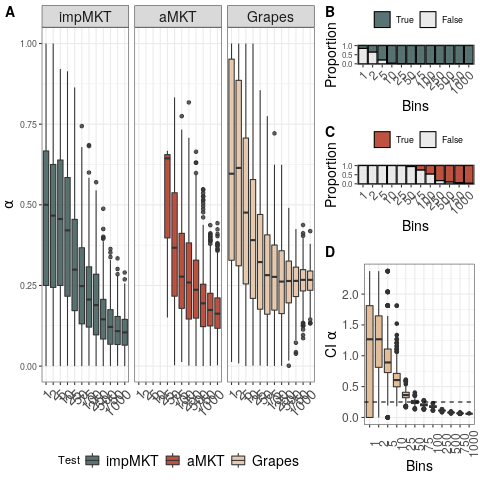

In [21]:
%%R -i binnedAfr -i dfAfr -i grapesPooledAfr -i PATH

library(cowplot)

binnedAfr = as.data.table(binnedAfr)
grapesPooledAfr = as.data.table(grapesPooledAfr)
grapesPooledAfr[['bins']] = as.factor(grapesPooledAfr[['bins']])
dfAfr = as.data.table(dfAfr)

ci = ggplot(grapesPooledAfr,aes(x = bins, y = alpha_range, fill=bins)) + geom_boxplot(show.legend=F) + labs(x = "Bins", y=expression(paste('CI ',alpha))) + theme_bw() + scale_fill_manual(values=c(rep("#e2bd9a",length(grapesPooledAfr[['bins']])))) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=90),axis.text.y = element_text(size=12),axis.title=element_text(size=14)) + ggtitle("") + geom_hline(yintercept=0.25,linetype='dashed')

d = dfAfr[test == 'imp2' | test == 'asymp1' | test == 'grapes']
d$test = factor(d$test,levels=c('imp2','asymp1','grapes'))
levels(d$test) = c('impMKT','aMKT','Grapes')

p = ggplot(d) + geom_boxplot(aes(x = bins, y = value, fill=test),alpha=0.8,show.legend=T) + labs(x='',y=expression(alpha)) + theme_bw() + ylim(c(0,1)) + scale_fill_manual(values=c("#30504f","#ab2710","#e2bd9a"),name = "Test", labels = c("impMKT", "aMKT","Grapes")) + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=14,angle=45,hjust=1,vjust=1),axis.title=element_text(size=14),legend.position="bottom",legend.text=element_text(size=14))
p = p + facet_wrap(~test)


fraction = binnedAfr[test=='imp2']
fraction[['TRUE']] = fraction[['count']]/1000
fraction[['FALSE']]= 1 - fraction[['TRUE']]
fraction = melt(fraction,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction = ggplot(fraction) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#30504f","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

fraction2 = binnedAfr[test=='asymp1']
fraction2[['TRUE']] = fraction2[['count']]/1000
fraction2[['FALSE']]= 1 - fraction2[['TRUE']]
fraction2 = melt(fraction2,id.vars=c('test','pop','bins'),measure.vars=c('TRUE','FALSE'))

pFraction2 = ggplot(fraction2) + geom_bar(stat="identity", aes(x=as.factor(bins), y=value,fill=variable),alpha=0.8, color="black") + theme_bw() + theme(strip.text=element_text(size=14),axis.text.x = element_text(size=12,angle=45,hjust=1,vjust=1),axis.text.y = element_text(size=8),axis.title=element_text(size=14),legend.position="top") + xlab("Bins") + ylab("Proportion") + scale_fill_manual(values=c("#ab2710","gray90"),name = "", labels = c("True", "False")) + scale_y_continuous(breaks=seq(0,1,0.5))

tmp = plot_grid(pFraction,pFraction2,ci,ncol = 1,rel_heights = c(0.5,0.5,1),labels=c('B','C','D'))
pgrid = plot_grid(p,tmp,ncol=2,rel_widths = c(2, 1),labels=c('A',''))

ggsave(pgrid,filename=paste0(PATH,"/results/pooled/afrPooled.svg"),dpi=600,width=14)
ggsave(pgrid,filename=paste0(PATH,"/results/pooled/afrPooled.png"),dpi=600,width=14)

pgrid

In [143]:
tmp = pd.concat([dfZi,dfAfr]).groupby(['test','bins','pop']).value.describe(percentiles=[0.05,0.5,0.95]).reset_index();tmp

,test,bins,pop,count,mean,std,min,5%,50%,95%,max
0,asymp1,1,AFR,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,asymp1,1,ZI,1.0,0.887922,NaN,0.887922,0.887922,0.887922,0.887922,0.887922
2,asymp1,2,AFR,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,asymp1,2,ZI,3.0,0.876362,0.017385,0.864337,0.864748,0.868453,0.893511,0.896295
4,asymp1,5,AFR,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
237,std,500,ZI,1000.0,0.375069,0.049926,0.215000,0.289950,0.375000,0.455050,0.514000
238,std,750,AFR,1000.0,-0.436287,0.059938,-0.652000,-0.532000,-0.436000,-0.340000,-0.249000
239,std,750,ZI,1000.0,0.378642,0.039108,0.259000,0.312950,0.379000,0.441050,0.505000
240,std,1000,AFR,1000.0,-0.438247,0.051546,-0.596000,-0.525000,-0.438000,-0.356000,-0.263000


In [144]:
df = tmp[(tmp.test == 'imp2') | (tmp.test == 'asymp1') | (tmp.test == 'grapes')]
tmpCi = np.round(df[['mean']],3).astype(str).values + " (" + np.round(df[['5%']],3).astype(str).values + " - " + np.round(df[['95%']],3).astype(str) + ")"
dfPooled = pd.concat([df.loc[:,['test','pop','bins']],tmpCi],axis=1)

dfPooled['pop'] = dfPooled['pop'].str.upper()

dfPooled = pd.pivot_table(dfPooled.sort_values(['pop','test','bins']),index=['pop','test'],columns='bins',values=['95%'],aggfunc=lambda x: ' '.join(x))

dfPooled.to_csv(PATH + "/results/pooled/dfPooled.tsv",sep='\t',index=True)

In [142]:
grapesPooled = pd.concat([grapesPooledZi,grapesPooledAfr])
grapesPooled['pop'] = grapesPooled['pop'].str.upper()

grapesPooled.groupby(['test','bins','pop']).alpha_range.describe()

count      mean       std     min       25%      50%  \
test   bins pop                                                          
grapes 1    AFR   705.0  1.117312  0.890850  0.0000  0.000000  1.26740   
            ZI    583.0  1.055210  0.670519  0.0000  0.559650  1.06730   
       2    AFR   940.0  1.205276  0.708670  0.0000  0.812700  1.26730   
            ZI    952.0  0.900864  0.465217  0.0000  0.597575  0.84910   
       5    AFR   998.0  0.942269  0.353399  0.0000  0.727200  0.89110   
            ZI   1000.0  0.496199  0.195752  0.0000  0.365000  0.47900   
       10   AFR  1000.0  0.616544  0.178319  0.1820  0.496800  0.60605   
            ZI   1000.0  0.312559  0.097303  0.0900  0.238900  0.30510   
       25   AFR  1000.0  0.362880  0.069476  0.1640  0.320000  0.36300   
            ZI   1000.0  0.182845  0.039554  0.0820  0.154750  0.18095   
       50   AFR  1000.0  0.250917  0.036690  0.1320  0.226000  0.25150   
            ZI   1000.0  0.124482  0.020831  0.0750  0.109825  0.12400   
       75   AFR  1000.0  0.203456  0.024217  0.1270  0.189000  0.20310   
            ZI   1000.0  0.100695  0.013847  0.0610  0.091000  0.10100   
       100  AFR  1000.0  0.175601  0.019044  0.1110  0.162000  0.17600   
            ZI   1000.0  0.086970  0.010317  0.0569  0.080000  0.08700   
       250  AFR  1000.0  0.111530  0.007982  0.0850  0.107000  0.11100   
            ZI   1000.0  0.055196  0.004128  0.0440  0.052000  0.05500   
       500  AFR  1000.0  0.080525  0.004117  0.0680  0.078000  0.08010   
            ZI   1000.0  0.040044  0.002131  0.0340  0.038000  0.04000   
       750  AFR  1000.0  0.067182  0.002680  0.0600  0.066000  0.06700   
            ZI   1000.0  0.033474  0.001448  0.0300  0.032000  0.03400   
       1000 AFR  1000.0  0.059406  0.002005  0.0540  0.058000  0.06000   
            ZI   1000.0  0.029666  0.001148  0.0280  0.028900  0.03000   

                      75%     max  
test   bins pop                    
grapes 1    AFR  1.811500  2.3715  
            ZI   1.520700  2.3715  
       2    AFR  1.646600  2.3715  
            ZI   1.155300  2.3715  
       5    AFR  1.109000  2.3715  
            ZI   0.599200  1.6466  
       10   AFR  0.714000  1.8115  
            ZI   0.375900  0.7140  
       25   AFR  0.407925  0.6130  
            ZI   0.209900  0.3249  
       50   AFR  0.276000  0.4030  
            ZI   0.138000  0.2200  
       75   AFR  0.220000  0.2761  
            ZI   0.111000  0.1440  
       100  AFR  0.189000  0.2301  
            ZI   0.094000  0.1230  
       250  AFR  0.117000  0.1330  
            ZI   0.058000  0.0700  
       500  AFR  0.083000  0.0929  
            ZI   0.042000  0.0460  
       750  AFR  0.069000  0.0750  
            ZI   0.034000  0.0380  
       1000 AFR  0.060900  0.0660  
            ZI   0.030000  0.0340